Diana's Code:

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', 999)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

sns.set_style("darkgrid")

In [2]:
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv') 

## 2: Exploratory Data Analysis

In [3]:
diabetes.head()

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some o

In [4]:
diabetes.shape

(3220, 95)

In [5]:
diabetes.describe()

,CountyFIPS,race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three or more 

In [6]:
diabetes.dtypes

County                                                                               object
State                                                                                object
CountyFIPS                                                                            int64
Diabetes_Number                                                                      object
Obesity_Number                                                                       object
                                                                                     ...   
sex and age_total population_18 years and over_female                                 int64
sex and age_total population_18 years and over_sex ratio (males per 100 females)    float64
sex and age_total population_65 years and over_1                                      int64
sex and age_total population_65 years and over_male                                   int64
sex and age_total population_65 years and over_female                           

### Data Preprocessing

In [7]:
diabetes = diabetes.apply(pd.to_numeric, errors = 'coerce')
diabetes.dtypes

County                                                                              float64
State                                                                               float64
CountyFIPS                                                                            int64
Diabetes_Number                                                                     float64
Obesity_Number                                                                      float64
                                                                                     ...   
sex and age_total population_18 years and over_female                                 int64
sex and age_total population_18 years and over_sex ratio (males per 100 females)    float64
sex and age_total population_65 years and over_1                                      int64
sex and age_total population_65 years and over_male                                   int64
sex and age_total population_65 years and over_female                           

In [8]:
diabetes_normalize = diabetes.drop (["CountyFIPS", "race_total population"], axis = 1).div(diabetes['race_total population'], axis = "index")
diabetes_normalize['CountyFIPS'] = diabetes['CountyFIPS']
diabetes_normalize['race_total population'] = diabetes['race_total population']

In [9]:
diabetes_normalize.head()

,County,State,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and 

In [10]:
diabetes_normalize.describe()

,County,State,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and 

### Visualization and Plotting

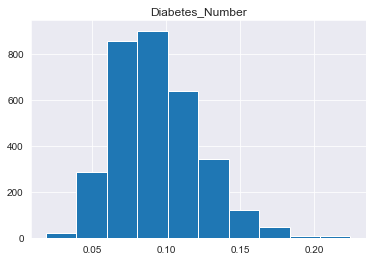

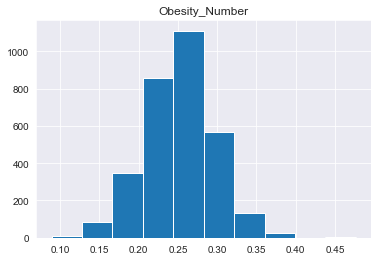

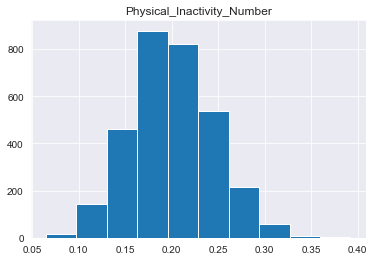

In [11]:
diabetes_normalize.hist(column='Diabetes_Number')
diabetes_normalize.hist(column='Obesity_Number')
diabetes_normalize.hist(column='Physical_Inactivity_Number')
plt.show()

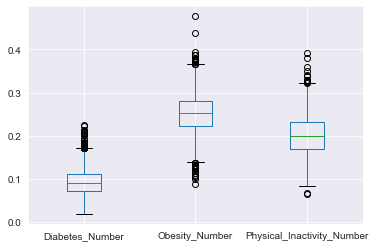

In [12]:
boxplot = diabetes_normalize.boxplot(column=['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number'])

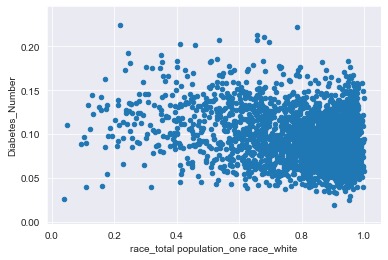

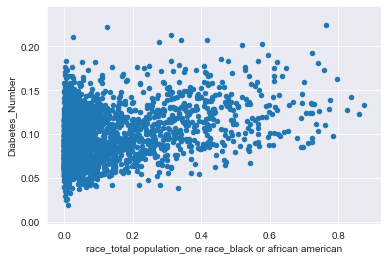

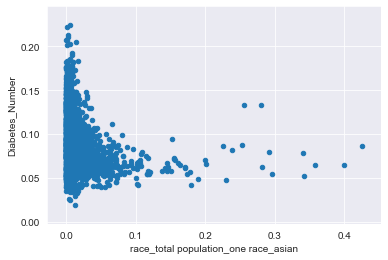

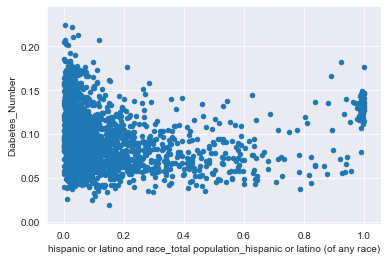

In [13]:
diabetes_normalize.plot.scatter(x='race_total population_one race_white', y='Diabetes_Number')
diabetes_normalize.plot.scatter(x='race_total population_one race_black or african american', y='Diabetes_Number')
diabetes_normalize.plot.scatter(x='race_total population_one race_asian', y='Diabetes_Number')
diabetes_normalize.plot.scatter(x='hispanic or latino and race_total population_hispanic or latino (of any race)', y='Diabetes_Number')


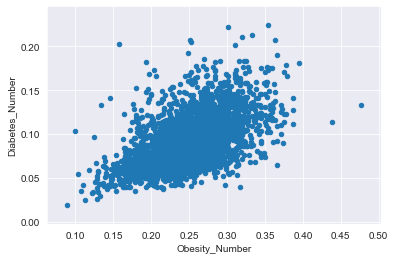

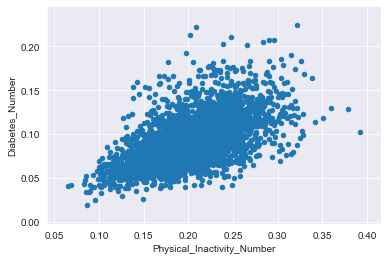

In [14]:
diabetes_normalize.plot.scatter(x='Obesity_Number', y='Diabetes_Number')
diabetes_normalize.plot.scatter(x='Physical_Inactivity_Number', y='Diabetes_Number')

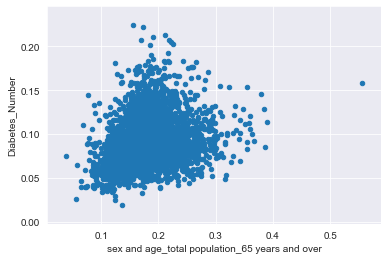

In [15]:
diabetes_normalize.plot.scatter(x='sex and age_total population_65 years and over', y='Diabetes_Number')

### Covariance and Correlation

In [16]:
diabetes_normalize.cov(min_periods=1)

,County,State,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and 

In [17]:
diabetes_normalize.corr(method='pearson', min_periods=1)

,County,State,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and 

## 3: Prepare to Fit Model

### 3.1: Data Cleaning

In [20]:
diabetes_normalize = diabetes_normalize.drop(['County', 'State'], axis = 1)
diabetes_normalize.head()

,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population_one race,race_total population_two or more races,race_total population_one race_1,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_1,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total po

In [19]:
np.nanquantile(diabetes_normalize['Diabetes_Number'], q=0.75)

0.11206083766388233